In [1]:
from __future__ import annotations
import nibabel as nib
from nibabel.freesurfer import io as fsio
from nibabel.freesurfer import read_geometry
import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
from pathlib import Path
import vtk
from ipyfilechooser import FileChooser
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# Make sure we're using the Jupyter backend
pv.set_jupyter_backend('trame')
pv.global_theme.trame.jupyter_extension_enabled = True
import os
os.environ["PYVISTA_OFF_SCREEN"] = "true" 

In [2]:


def show_cross_sections(
    vol,
    ijk,
    verts_vox=None,           # optional Nx3 surface vertices in voxel space
    atol=0.5,                 # slice thickness for outline mask (in voxels)
    cmap="gray",
    window=None,              # (vmin, vmax); if None uses percentiles
    fig=None,
    figsize=(12, 4),
    suptitle=None,
):
    """
    Plot axial (k), coronal (j), sagittal (i) slices through a voxel-space point.

    vol:       (nx, ny, nz) numpy array
    ijk:       (i, j, k) in voxel indices (ints or floats)
    verts_vox: optional (N,3) surface vertices in voxel space for overlay
    atol:      +/- thickness around the slice for overlay masking
    window:    (vmin, vmax) intensity window; if None uses (1, 99) percentiles
    """
    vol = np.asarray(vol)
    i0, j0, k0 = np.round(ijk).astype(int)

    # safe-guard bounds
    nx, ny, nz = vol.shape
    i0 = np.clip(i0, 0, nx - 1)
    j0 = np.clip(j0, 0, ny - 1)
    k0 = np.clip(k0, 0, nz - 1)

    # choose window
    if window is None:
        vmin, vmax = np.percentile(vol, (1, 99))
    else:
        vmin, vmax = window

    # prepare figure/axes
    if fig is None:
        fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)
    else:
        axes = fig.axes[:3]  # reuse first three axes

    ax_sag, ax_cor, ax_axi = axes  # left→right: sagittal, coronal, axial
    for ax in axes:
        ax.cla()  # clear

    # ---- Sagittal (i fixed) ----
    # base (unrotated) shape = (nz, ny), coords (x=j, y=k)
    sag_unrot = vol[i0, :, :].T
    H_sag, W_sag = sag_unrot.shape  # H = nz, W = ny
    sag = np.rot90(sag_unrot, k=1)  # 90° CCW
    
    ax_sag.imshow(sag, cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    
    # crosshairs after k=1: x' = k0, y' = H-1 - j0
    ax_sag.axvline(k0, color="cyan", lw=0.8)
    ax_sag.axhline((H_sag - 1) - j0, color="magenta", lw=0.8)
    
    # surface outline: (j,k) -> (x',y') = (k, H-1-j)
    if verts_vox is not None:
        mask = np.isclose(verts_vox[:, 0], i0, atol=atol)
        pts = verts_vox[mask][:, [1, 2]]                    # (j, k)
        x_r = pts[:, 1]
        y_r = (H_sag - 1) - pts[:, 0]
        ax_sag.scatter(x_r, y_r, s=0.2, c="r", alpha=0.6)
    
    ax_sag.set_title(f"Sagittal i={i0}")
    ax_sag.set_xlabel("j"); ax_sag.set_ylabel("k")
    
    
    # ---- Axial (j fixed) ----
    # no rotation here; shape = (nz, nx), coords (x=i, y=k)
    axi = vol[:, j0, :].T
    ax_axi.imshow(axi, cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    
    ax_axi.axvline(i0, color="cyan", lw=0.8)
    ax_axi.axhline(k0, color="magenta", lw=0.8)
    
    if verts_vox is not None:
        mask = np.isclose(verts_vox[:, 1], j0, atol=atol)
        ax_axi.scatter(verts_vox[mask, 0], verts_vox[mask, 2], s=0.2, c="r", alpha=0.6)
    
    ax_axi.set_title(f"Axial j={j0}")
    ax_axi.set_xlabel("i"); ax_axi.set_ylabel("k")
    
    
    # ---- Coronal (k fixed) ----
    cor_unrot = vol[:, :, k0].T
    H_cor, W_cor = cor_unrot.shape  # H = ny, W = nx
    cor = np.rot90(cor_unrot, k=2)  # 180° rotation
    cor = np.fliplr(cor)            # mirror left-right to match FS orientation
    
    ax_cor.imshow(cor, cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    
    # Crosshairs: after k=2 + flip
    # First handle k=2 mapping: x' = W-1 - i0, y' = H-1 - j0
    x_r = (W_cor - 1) - i0
    y_r = (H_cor - 1) - j0
    # Then flip x-axis: x'' = W_cor - 1 - x_r = i0
    x_r = i0
    
    ax_cor.axvline(x_r, color="cyan", lw=0.8)
    ax_cor.axhline(y_r, color="magenta", lw=0.8)
    
    # Surface outline: (i,j) -> after k=2 = (W-1-i, H-1-j), then flip x: i
    if verts_vox is not None:
        mask = np.isclose(verts_vox[:, 2], k0, atol=atol)
        pts = verts_vox[mask][:, [0, 1]]        # (i, j)
        x_surf = pts[:, 0]                      # flip cancels i-rotation
        y_surf = (H_cor - 1) - pts[:, 1]        # vertical flip from k=2
        ax_cor.scatter(x_surf, y_surf, s=0.2, c="r", alpha=0.6)
    
    ax_cor.set_title(f"Coronal k={k0}")
    ax_cor.set_xlabel("i"); ax_cor.set_ylabel("j")

    if suptitle:
        fig.suptitle(suptitle)

    plt.show(block=False)
    return fig, (ax_sag, ax_axi, ax_cor)

In [3]:
base_path = Path("/data_store2/neuropixels/imaging")
subject_id = "NP157"
hemisphere = "l"

In [4]:
fc_flair = FileChooser(base_path / subject_id)
display(fc_flair)

FileChooser(path='/data_store2/neuropixels/imaging/NP157', filename='', title='', show_hidden=False, select_de…

In [7]:
mri_path = Path(fc_flair.selected)
surf_path = base_path / subject_id / "surf" / f"{hemisphere}h.pial"
curv_path = base_path / subject_id / "surf" / f"{hemisphere}h.curv"

In [8]:
img = nib.load(mri_path)
vol = img.get_fdata()
nx = vol.shape[0]
vox2ras = img.header.get_vox2ras()
vox2ras_tkr = img.header.get_vox2ras_tkr()   # tkregister RAS

# --- Load surface (tkRAS) and convert to voxel space ---
verts_tkr, faces = nib.freesurfer.read_geometry(surf_path)
verts_h = np.c_[verts_tkr, np.ones(len(verts_tkr))]
tkr2vox = np.linalg.inv(vox2ras_tkr)
verts_vox = (tkr2vox @ verts_h.T).T[:, :3]

# PyVista polydata in voxel space
faces_pv = np.c_[np.full(len(faces), 3), faces].ravel()
surf = pv.PolyData(verts_vox, faces_pv)

# Wrap volume for PyVista and set voxel spacing/origin
volume = pv.wrap(vol)
volume.spacing = img.header.get_zooms()[:3]  # voxel size
volume.origin = (0.0, 0.0, 0.0)

mirror_lr = True  # set False to disable

vol_disp = vol
surf_disp = surf.copy(deep=True)

if mirror_lr:
    # Flip volume in i (x) dimension for display
    vol_disp = vol[::-1, :, :].copy()

    # Flip surface X coords for display: i' = (nx-1) - i
    pts = surf_disp.points.copy()
    pts[:, 0] = (nx - 1) - pts[:, 0]
    surf_disp.points = pts

def undo_mirror(p_disp):
    if not mirror_lr: 
        return np.array(p_disp, float)
    p = np.array(p_disp, float)
    p[0] = (nx - 1) - p[0]
    return p

def apply_mirror(p_true):
    if not mirror_lr: 
        return np.array(p_true, float)
    p = np.array(p_true, float)
    p[0] = (nx - 1) - p[0]
    return p


In [9]:
# Get the curv color mapping
curv_vals = nib.freesurfer.read_morph_data(curv_path).astype(np.float32)
if curv_vals.shape[0] != surf_disp.n_points:
    raise ValueError("curv length does not match surface vertices")

def fs_scale_curv(curv, pct=98, gamma=0.5, flip_sign=False):
    c = np.nan_to_num(curv, nan=0.0)
    if flip_sign:  # if your colors look inverted vs FreeView
        c = -c
    S = np.nanpercentile(np.abs(c), pct) or 1.0
    c = np.clip(c, -S, S)
    c = np.sign(c) * (np.abs(c) ** gamma)          # nonlinear boost
    denom = np.max(np.abs(c)) or 1.0
    return c / denom     

curv_fs = fs_scale_curv(curv_vals, pct=98, gamma=0.5, flip_sign=False)
surf_disp.point_data["curv_fs"] = curv_fs

fs_cmap = LinearSegmentedColormap.from_list("fs_rg", ["lime", "red"])

In [10]:
pl = pv.Plotter(notebook=True)
pl.background_color='black'
pl.add_mesh(surf_disp,
                 pickable=True,
                 scalars='curv_fs',
                 cmap=fs_cmap,
                 clim=[-1, 1],
                 smooth_shading=True,#set to false if you want to see the mesh
                 show_scalar_bar=False,
                )
pl.reset_camera()
if hemisphere == "l":
    pl.view_zy()
    pl.camera.Roll(190)
    pl.camera.Azimuth(-15)
else: 
    pl.view_yz()
    pl.camera.Roll(-100)
    pl.camera.Azimuth(15)
    
selected_point = {}


def callback(point):
    # clear previous overlays
    for nm in ("pick_label", "hud_label", "pick_dot"):
        try: pl.remove_actor(nm, render=False)
        except Exception: pass

    # math
    point_vox_float = undo_mirror(point)
    ras = (vox2ras_tkr @ np.r_[point_vox_float, 1.0])[:3]
    point_vox_int = np.round(point_vox_float).astype(int)

    selected_point['ras'] = ras
    selected_point['vox'] = point_vox_int

    # (optional) draw a small dot at the picked 3D point
    pl.add_points(point, color='blue', point_size=12,
                  render_points_as_spheres=True, name='pick_dot')

    # HUD text in the corner (not at the point)
    txt = (
        f"Flair Vox (int): {point_vox_int[0]:.0f}, {point_vox_int[1]:.0f}, {point_vox_int[2]:.0f}\n"
        f"RAS (mm): {ras[0]:.2f}, {ras[1]:.2f}, {ras[2]:.2f}"
    )
    pl.add_text(
        txt,
        position="lower_right",   # or "upper_right", "lower_left", "lower_right", or (x, y)
        font_size=14,
        color="white",
        name="hud_label",
    )

    pl.render()

    
pl.enable_surface_point_picking(
    callback=callback,
    show_point=False,
    picker='cell',
    show_message=False
)
def sc(obj, event):
    base_path = f"/data_store2/neuropixels/imaging/{subject_id}/{subject_id}_localization"
    ext = ".png"
    path = base_path + ext
    counter = 1
    
    # Check if file exists and increment suffix until free
    while os.path.exists(path):
        path = f"{base_path}_{counter}{ext}"
        counter += 1

    pl.screenshot(path)
    
pl.iren.add_observer("MiddleButtonPressEvent", sc)
    
pl.show()
                                     

2025-10-20 07:22:34.564 (  12.577s) [    7FE51B3B4740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x7fe45abf1ad0_0" src="http://localhost:8888/trame…

In [12]:
print(f"ras: [{selected_point['ras'][0]:.2f}, {selected_point['ras'][1]:.2f}, {selected_point['ras'][2]:.2f}]")
print(f"vox: [{selected_point['vox'][0]:.0f}, {selected_point['vox'][1]:.0f}, {selected_point['vox'][2]:.0f}]")


KeyError: 'ras'

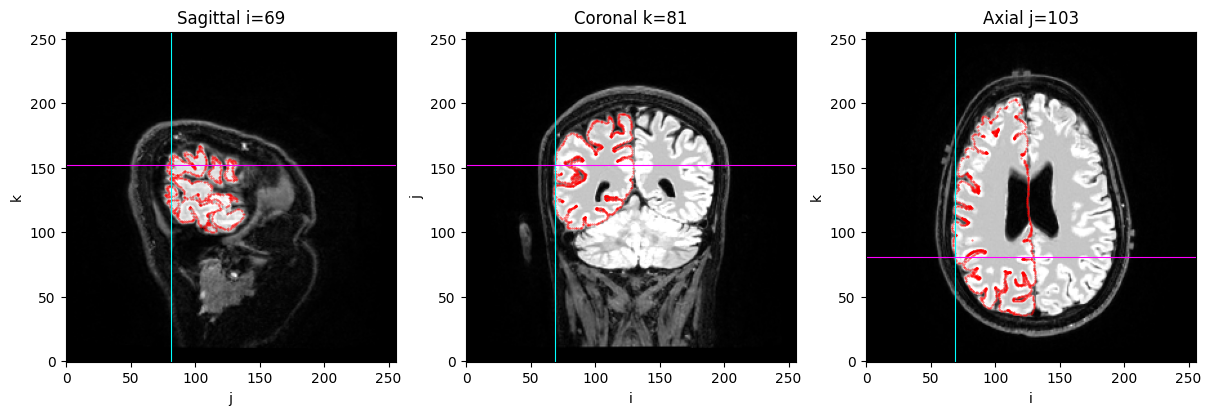

In [10]:
fig, axes = show_cross_sections(vol, ijk=selected_point['vox'], verts_vox=verts_vox, atol=0.5)

In [39]:
def sc(obj, event):
    plotter.screenshot('./test1.png')

In [43]:
sphere = pv.Sphere()
plotter = pv.Plotter(off_screen=True)
actor = plotter.add_mesh(sphere)
plotter.iren.add_observer("MiddleButtonPressEvent", cb)
plotter.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x7fb1148f9c10_17" src="http://127.0.0.1:8888/tram…